In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import time


class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0  # 记录当前智能体位置的横坐标
        self.y = self.nrow - 1  # 记录当前智能体位置的纵坐标

    def step(self, action):  # 外部调用这个函数来改变当前位置
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:  # 下一个位置在悬崖或者目标
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self):  # 回归初始状态,起点在左上角
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x




In [2]:
from minirl import DynaQPlus
from minirl.core.dynaQ_plus import TimeModel,simpleModel
import hirlite

mdb = hirlite.Rlite(encoding='utf8',path="model.db")

hdb = hirlite.Rlite(encoding='utf8',path="his.db")
sdb = hirlite.Rlite(encoding='utf8',path="score.db")

In [5]:
def DynaQ_CliffWalking(n_planning):
    ncol = 12
    nrow = 4
    env = CliffWalkingEnv(ncol, nrow)
    epsilon = 0.01
    alpha = 0.1
    gamma = 0.9
    state_space = [i for i in range(nrow * ncol)]
    actions_list = [i for i in range(4)]
    #dyna_model = TimeModel(actions_list)
    dyna_model = simpleModel()
    agent = DynaQPlus(actions_list,
        eps=0.01,
        n=10,
        gamma=0.95,
        alpha=0.1,
        alpha_decay=0.001,
        model_db=mdb,
        score_db=sdb,
        his_db=hdb,)
    #agent = DynaQ(ncol, nrow, epsilon, alpha, gamma, n_planning)
    num_episodes = 300  # 智能体在环境中运行多少条序列

    return_list = []  # 记录每一条序列的回报
    for i in range(10):  # 显示10个进度条
        # tqdm的进度条功能
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
                episode_return = 0
                state = env.reset()

                done = False
                while not done:
                    model_id = f"{n_planning}:model"
                    action = agent.act(state,model_id,request_id=1,save_his=False)
                    #print(agent.model)
                    #print(actions_list)
                    #action = random.choice(actions_list)
                    action =int( action[0])
                    next_state, reward, done = env.step(action)

                    agent.update_state_action_hist(1, state, action, next_state, reward, model_id)
                    
                    #print(next_state,reward,type(reward))
                    episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                    agent.learn(1,reward, model_id ,n_planning, dyna_model=dyna_model)
                    #agent.update(state, action, reward, next_state,"local_model")

                    #print(f,score_key1)
                    state = next_state
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list

Q-planning步数为：0


Iteration 2: 100%|█| 30/30 [00:06<00:00,  4.66it/s, episode=90, return=-268.700]
Iteration 3: 100%|█| 30/30 [00:07<00:00,  3.87it/s, episode=120, return=-319.400
Iteration 4: 100%|█| 30/30 [00:09<00:00,  3.24it/s, episode=150, return=-566.600
Iteration 5: 100%|█| 30/30 [00:09<00:00,  3.09it/s, episode=180, return=-135.200
Iteration 6: 100%|█| 30/30 [00:23<00:00,  1.29it/s, episode=210, return=-552.200
Iteration 7: 100%|█| 30/30 [00:03<00:00,  8.58it/s, episode=240, return=-174.100
Iteration 9: 100%|█| 30/30 [00:00<00:00, 33.26it/s, episode=300, return=-22.900]


Q-planning步数为：2


Iteration 0: 100%|█| 30/30 [00:49<00:00,  1.64s/it, episode=30, return=-1943.100
Iteration 1: 100%|█| 30/30 [00:49<00:00,  1.64s/it, episode=60, return=-897.800]
Iteration 2: 100%|█| 30/30 [01:03<00:00,  2.10s/it, episode=90, return=-1076.300
Iteration 3: 100%|█| 30/30 [00:44<00:00,  1.49s/it, episode=120, return=-947.600
Iteration 4: 100%|█| 30/30 [01:02<00:00,  2.09s/it, episode=150, return=-403.600
Iteration 9: 100%|█| 30/30 [00:01<00:00, 29.74it/s, episode=300, return=-17.000]


Q-planning步数为：20


Iteration 0: 100%|█| 30/30 [00:00<00:00, 372.02it/s, episode=30, return=-100.000
Iteration 9: 100%|█| 30/30 [00:05<00:00,  5.18it/s, episode=300, return=-26.300]


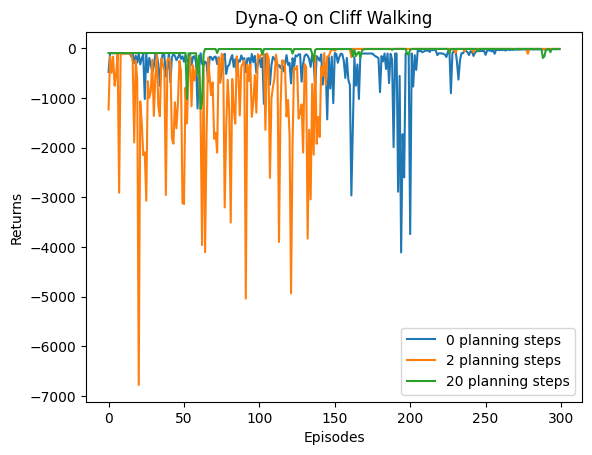

In [6]:
np.random.seed(0)
random.seed(0)
n_planning_list = [0,2,20]
for n_planning in n_planning_list:
    print('Q-planning步数为：%d' % n_planning)
    time.sleep(0.5)
    return_list = DynaQ_CliffWalking(n_planning)
    episodes_list = list(range(len(return_list)))
    plt.plot(episodes_list,
             return_list,
             label=str(n_planning) + ' planning steps')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dyna-Q on {}'.format('Cliff Walking'))
plt.show()

In [8]:
dyna_model.model

NameError: name 'dyna_model' is not defined